Установка `cupy`, `pyfftw`

In [ ]:
#!pip install pyfftw
!conda install -c conda-forge pyfftw

In [ ]:
!conda install -c conda-forge cupy

### Архитектура обмена данными с GPU
![gpu](GPU.png "GPU")

In [2]:
import cupy as cp
import numpy as np
from pyfftw.interfaces.numpy_fft import fft

import matplotlib.pyplot as plt
from time import perf_counter

In [3]:
cp

<module 'cupy' from 'c:\\Users\\vonGostev\\miniconda3\\lib\\site-packages\\cupy\\__init__.py'>

CuPy -- простой и удобный способ ускорения кода с помощью видеокарты. Основные особенности:
1. Массивы `cupy` полностью совместимы по интерфейсам с массивами `numpy`
2. Доступно большое число ускоренных функций из `numpy` и `scipy`
https://docs.cupy.dev/en/stable/reference/comparison.html

Что нужно помнить:
1. Для вычислений на видеокарте данные из RAM надо передать в память GPU. Это медленная операция, поэтому лучше передавать данные по возможности большими порциями и до, а не в процессе вычислений. Выделение памяти на GPU производится с помощью функций `cp.array` и `cp.asarray`.
2. Циклы `python` очень медленные и могут тормозить вычисления при использовании `cupy` даже больше, чем при использовании `numpy`.
3. Ускорение кода растет с увеличением объема обрабатываемых данных.
4. Параллелизация кода с помощью потоков/процессов работает не очень, надо тестировать индивидуально.

Объявление массивов `cupy`

In [7]:
cp.array([1, 2, 3])
cp.asarray([1, 2, 3])
cp.asanyarray([1, 2, 3])

array([1, 2, 3])

In [12]:
%timeit cp.array([1, 2, 3])

105 µs ± 6.62 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%timeit cp.asarray([1, 2, 3])

100 µs ± 6.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
%timeit np.array([1, 2, 3])

712 ns ± 36.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [15]:
%timeit np.asarray([1, 2, 3])

746 ns ± 64 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [16]:
%timeit np.ones(10000)

7 µs ± 702 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [18]:
%timeit cp.ones(10000)

25.6 µs ± 1.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [35]:
%%timeit 
a = np.random.random(size=(1024, 1024)).astype(np.float32)
b = np.random.random(size=(1024, 1024)).astype(np.float32)
a @ b

57.9 ms ± 2.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
%%timeit
a = cp.random.random(size=(1024, 1024)).astype(np.float32)
b = cp.random.random(size=(1024, 1024)).astype(np.float32)
a @ b

1.33 ms ± 4.19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [38]:
%%timeit
a = np.random.random(size=(1024, 1024)).astype(np.float32)
b = np.random.random(size=(1024, 1024)).astype(np.float32)
np.einsum('ij,jk->ik', a, b)

268 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%timeit
a = cp.random.random(size=(1024, 1024)).astype(np.float32)
b = cp.random.random(size=(1024, 1024)).astype(np.float32)
cp.einsum('ij,jk->ik', a, b)

573 µs ± 71.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Так как код на GPU выполняется асинхронно, для анализа производительности стоит использовать рекомендации https://docs.cupy.dev/en/stable/user_guide/performance.html
хотя в боевом коде удобнее использовать `time.perf_counter`, который дает достаточно точные результаты из-за синхронности всего остального кода. На простых операциях и маленьких массивах выигрыша не будет из-за низкой скорости обмена данными с GPU.

In [3]:
from cupyx.profiler import benchmark
# Код работает, начиная с cupy 10.0
print(benchmark(cp.zeros, (100000,), n_repeat=10))

zeros               :    CPU:   30.330 us   +/- 9.828 (min:   20.600 / max:   51.600) us     GPU-0:   85.027 us   +/-17.467 (min:   57.120 / max:  117.760) us


### Быстрое преобразование Фурье
О дискретном преобразовании Фурье (ДПФ) неплохо написано [тут](http://kprf.mipt.ru/attachments/article/51/dft.pdf), [тут](https://habr.com/ru/post/196374/) и [тут (на английском)](https://www.robots.ox.ac.uk/~sjrob/Teaching/SP/l7.pdf).

Про быстрое преобразование Фурье (БПФ), которое имеет существенный выигрыш по вычислительной сложности и чаще всего используется в пакетах численных расчетов, можно почитать [тут же (на английском)](https://www.robots.ox.ac.uk/~sjrob/Teaching/SP/l7.pdf).

Рассмотрим различия в производительности `numpy` и `cupy` при вычислении БПФ. В силу "медленного" обмена данными с GPU стоит ожидать выигрыша CPU для малых объемов данных и выигрыша GPU для больших объемов данных.
Если мы пользуемся `numpy`, то пишем что-то такое:

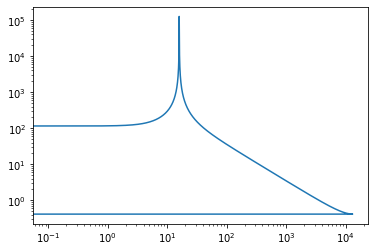

In [13]:
t = np.linspace(0, 10, 2 ** 18)
dt = t[1]
sig = np.sin(t * 100)
sp = np.fft.fft(sig)
plt.loglog(np.fft.fftfreq(len(sig), dt), np.abs(sp))
plt.show()

Стоит помнить, что частоты в `fft` растут пилообразно. Первая половина частотных коэффициентов отвечает за положительные частотные компоненты, а вторая -- за отрицательно частотные.

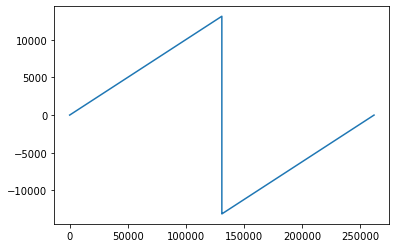

In [16]:
plt.plot(np.fft.fftfreq(len(sig), dt))
plt.show()

При использовании `cupy` код абсолютно такой же. Единственное отличие -- использование метода `.get()` при выводе графика. Это связано с тем, что массивы `cupy` лежат в памяти GPU, и `matplotlib` не умеет работать с такими данными.

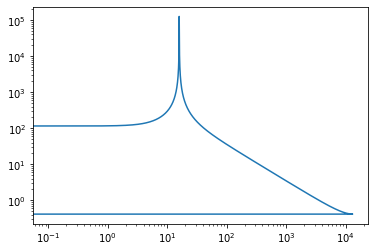

In [17]:
t = cp.linspace(0, 10, 2 ** 18)
dt = t[1]
sig = cp.sin(t * 100)
sp = cp.fft.fft(sig)
plt.loglog(cp.fft.fftfreq(len(sig), dt).get(), cp.abs(sp).get())
plt.show()

### Тестирование проивзодительности
Конечно, мы бы не стали мучиться с GPU, если бы это не давало нам выигрыша по производительности.
Протестируем `numpy.fft` и `cupy.fft` для разного объема данных (сигнал берется простой, синусоидальный). Для этого будем пользовать унифицированным подходом:

In [18]:
def test_fft(n_low, n_high, backend=np, n_repeat=10):
    times = []
    for n in range(n_low, n_high):
        t = backend.linspace(0, 10, 2 ** n)
        sig = backend.sin(t * 100)
        _times = []
        for r in range(n_repeat):
            t_start = perf_counter()
            backend.fft.fft(sig)
            t_end = perf_counter()
            _times.append(t_end - t_start)
        times.append(np.median(_times))
    return times

def test_fft_pyfftw(n_low, n_high, n_repeat=100):
    times = []
    for n in range(n_low, n_high):
        t = np.linspace(0, 10, 2 ** n)
        sig = np.sin(t * 100)
        _times = []
        for r in range(n_repeat):
            t_start = perf_counter()
            fft(sig, **{'planner_effort': 'FFTW_ESTIMATE',
                'overwrite_input': True,
                'threads': -1})
            t_end = perf_counter()
            _times.append(t_end - t_start)
        times.append(np.median(_times))
    return times

Построим графики времени выполнения `fft` (усреднено по 10 прогонам) для `numpy`, `cupy` и еще одной популярной библиотеки для БПФ -- `pyfftw` (оптимальный выбор для вычислений на CPU).

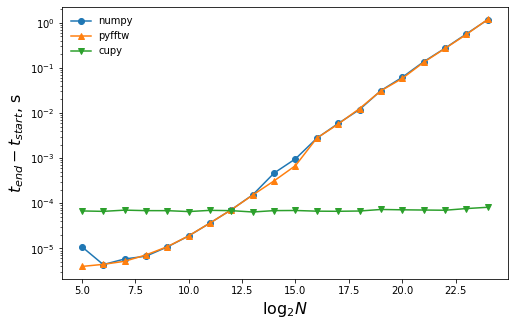

Wall time: 46.7 s


In [20]:
%%time
n_low = 5
n_high = 25
n_grid = np.arange(n_low, n_high)
plt.figure(figsize=(8,5))
plt.semilogy(n_grid, test_fft(n_low, n_high, backend=np), 'o-', label='numpy')
plt.plot(n_grid, test_fft(n_low, n_high), '^-', label='pyfftw')
plt.plot(n_grid, test_fft(n_low, n_high, backend=cp), 'v-', label='cupy')
plt.legend(frameon=False)
plt.xlabel('$\\log_2N$', fontsize=16)
plt.ylabel('$t_{end} - t_{start}$, s', fontsize=16)
plt.show()

Видно, что время вычислений на CPU растет линейно с ростом объема данных, а на GPU время практически постоянно и при объеме данных $2^{24}=16777216$ точек выигрыш составляет 4 порядка (секунды против 100 мкс).

### О единообразном коде `numpy` и `cupy`
Так как интерфейсы `numpy` и `cupy` в целом одинаковы, можно писать универсальный код, который при необходимости может быть выполнен на GPU. Если можно в явном виде импортировать `cupy`, то для этого можно воспользоваться встроенной в `cupy` функцией. Например:

In [ ]:
def mean_cpnp(sig):
    backend = cp.get_array_module(sig)
    return backend.mean(sig)

In [50]:
x = cp.array([1,2,3])
type(x.mean())

cupy.ndarray

Иногда необходимо обеспечить универсальность кода без явного импорта `cupy`. Тогда можно пользоваться таким подходом:

In [8]:
def getbackend(obj):
    module_name = type(obj).__module__.split('.')[0]
    if module_name in ['numpy', 'cupy']:
        return __import__(module_name)
    else:
        raise ValueError(
            f'Unknown backend `{module_name}`. Check object `{type(obj)}` type.')


def mean_cpnp(sig, backend=None):
    if backend is None:
        backend = getbackend(sig)
    return backend.mean(sig)